## Required Libraries

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [344]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet

## PARAMETERS

In [345]:
VALID_SIZE = 0.2
TEST_SIZE  = 0.1
BATCH_SIZE = 8
EPOCHS = 20
CUDA = False
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## DIRECTORIES

In [346]:
SRC_DIR=os.getcwd()
ROOT_DIR=os.path.join(SRC_DIR,'..')
IMAGE_DIR=os.path.join(ROOT_DIR,'images')
MASK_DIR=os.path.join(ROOT_DIR,"masks")

In [347]:
ROOT_DIR='C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\'

In [348]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [349]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks')
mask_on_image_path=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images')

In [350]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"img_out\\"+image_paths[i]

In [351]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [352]:
for i in range(len(mask_on_image_path)):
    mask_on_image_path[i]=ROOT_DIR+"masked_images\\"+mask_on_image_path[i]

In [353]:
image_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [354]:
mask_paths

['cfc_000234_75576fe22f704a23816456740bde3556.png',
 'cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'cfc_000249_38679c112bca4107ad224a6e7fc10c2e.png',
 'cfc_000250_8e8d9b03802545a0bcac9b7d2b9578f1.png',
 'cfc_000251_d99c886d896745b7817ed667618a954e.png',
 'cfc_000252_bc4465e2f56b43d092575c4c6833b648.png',
 'cfc_000253_a7471156614d473db7fe9e5bee2ee247.png',
 'cfc_000254_388a51e56525449796c6c07728494a51.png',
 'cfc_000255_f3b724c3232d41588e2eaa5074740d2e.png',
 'cfc_000256_0c84da99243c439fa8e4117c1a10e530.png',
 'cfc_000257_71569acad2364cd5b5ca50878673b381.png',
 'cfc_000258_81fa1134d54949209bf05a8624328ce2.png',
 'cfc_000259_06d409725bef4251af86afad57a12ee4.png',
 'cfc_000260

In [355]:
line_mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\

In [356]:
mask_on_image_path

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',


## Json2Mask

In [357]:
for i in range(len(image_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [358]:
mask=plt.imread(mask_paths[0])

In [359]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [360]:
mask=plt.imread(mask_paths[0],0)
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

In [361]:
def visualize_example_fs_mask_pair(image_paths,mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(mask_paths[random_idx],0)
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    

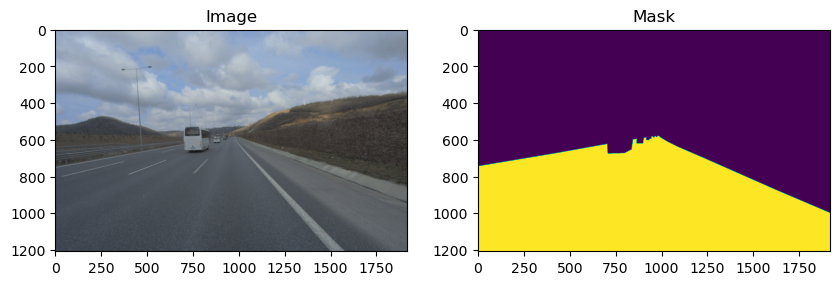

In [362]:
visualize_example_fs_mask_pair(image_paths,mask_paths)

In [363]:
def visualize_example_line_mask_pair(image_paths,line_mask_paths):
    random_idx=random.randint(0,len(image_paths))
    image=plt.imread(image_paths[random_idx])
    mask=plt.imread(line_mask_paths[random_idx])
    
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    

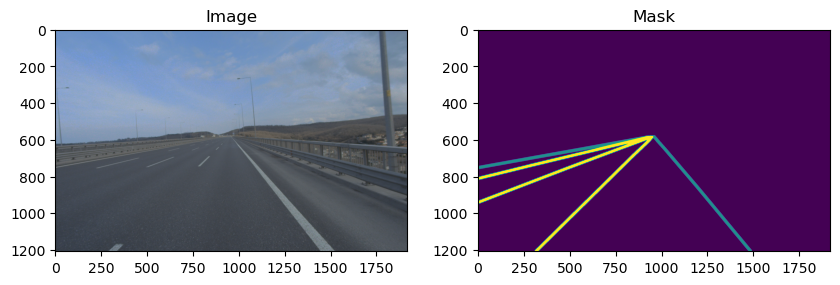

In [364]:
visualize_example_line_mask_pair(image_paths,line_mask_paths)

In [365]:
def visualize_example_mask_on_image_pair(image_paths,mask_paths):
    random_idx=random.randint(0,10)
    image=plt.imread(image_paths[random_idx])
    mask_on_image=plt.imread(mask_paths[random_idx])
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask_on_image)
    axs[1].set_title('Mask On Image')
    

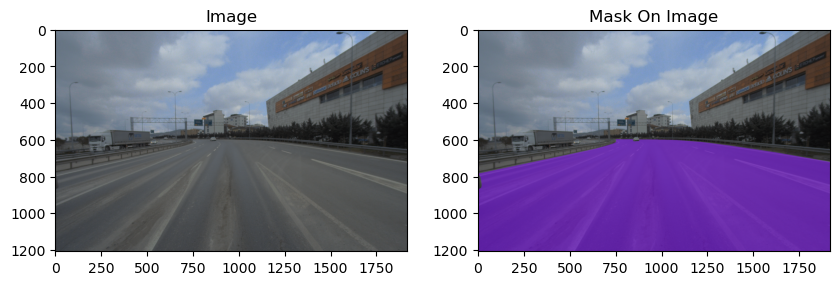

In [366]:
visualize_example_mask_on_image_pair(image_paths,mask_on_image_path)

In [367]:
image=plt.imread(image_paths[4])
mask=plt.imread(mask_paths[4])

In [368]:
print(f"Number of images:{len(image_paths)}")

Number of images:4660


In [369]:
print(f"Shape of the mask: {mask.shape}")
print(f"Shape of the images: {image.shape}")

Shape of the mask: (1208, 1920)
Shape of the images: (1208, 1920, 3)


In [370]:
for i,unique_val in enumerate(np.unique(mask)):
    print(i,unique_val)

0 0.0
1 0.003921569


In [371]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157]], dtype=float32)

# Preprocessing 

### torchlike_data() method

In [271]:
image=plt.imread(image_paths[0])

In [272]:
image_before_torchlike=image
print(f"Image shapes before torchlike_data() method {image_before_torchlike.shape}")

Image shapes before torchlike_data() method (224, 224, 3)


In [273]:
torch_like_data_example=preprocess.torchlike_data(image)

In [274]:
print(f"Image shapes before torchlike_data() method {torch_like_data_example.shape}")

Image shapes before torchlike_data() method (3, 224, 224)


We can see that at first our image has HeightxWidthxShape data format. Pytorch wants our images as ChannelxHeightxWidth format.

### onehot_encoder() method

One hot encoding is a method that provides us to convert categorical data into vectors. Fro now we have 2 categorical value wihich is pixel belong to freespace or not.

Returns a matrix containing as many channels as the number of unique values ​​in the input Matrix, where each channel represents a unique class.

In [33]:
example_mask=plt.imread(mask_paths[3])
one_hot_encoded=preprocess.one_hot_encoder(example_mask,n_class=2)

In [34]:
print(f"The dimensions of one hot encoded mask is {one_hot_encoded.shape}")

The dimensions of one hot encoded mask is (1208, 1920, 2)


In [35]:
image_paths[0]

'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000234_75576fe22f704a23816456740bde3556.png'

## tensorize_image method

In [36]:
list_image=[]
list_image.append(image_paths[0])

In [37]:
tensorized_images=preprocess.tensorize_image(list_image,(constant.HEIGHT,constant.WIDTH))

In [38]:
tensorized_images[0].shape

torch.Size([3, 224, 224])

In [39]:
tensorized_images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## tensorize_mask.() method

In [40]:
mask_paths

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000234_75576fe22f704a23816456740bde3556.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000235_a1468fa636f9496aabbec371327890c3.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000236_03a390ba28534f28a60a2d626f674103.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000244_bf75244a4b09401580da886b35c340d6.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000245_fa3c4302ca62471393518bb0df32b1c2.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000246_c18d4001d69044e295e65591cf0cb574.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000247_f5d4e0af272e4757b5b2c76a51692537.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_000248_f6fdb1a2623546a7b1d344059618598e.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\mask

In [41]:
tensorized_masks=preprocess.tensorize_mask(mask_paths,(constant.HEIGHT,constant.WIDTH),n_class=2)

KeyboardInterrupt: 

In [ ]:
tensorized_masks.shape

In [ ]:
tensorized_masks[3]

## Model Training

In [372]:
# PREPARE IMAGE AND MASK LISTS
image_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out", '*'))
image_path_list.sort()

mask_path_list = glob.glob(os.path.join("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks", '*'))
mask_path_list.sort()


In [373]:
# DATA CHECK
preprocess.image_mask_check(image_path_list, mask_path_list)

True

## Train, Valid and Test Data Split

In [374]:
indices = np.random.permutation(len(image_path_list))

# DEFINE TEST AND VALID INDICES
test_ind  = int(len(indices) * TEST_SIZE)
valid_ind = int(test_ind + len(indices) * VALID_SIZE)

# SLICE TEST DATASET FROM THE WHOLE DATASET
test_input_path_list = image_path_list[:test_ind]
test_label_path_list = mask_path_list[:test_ind]

# SLICE VALID DATASET FROM THE WHOLE DATASET
valid_input_path_list = image_path_list[test_ind:valid_ind]
valid_label_path_list = mask_path_list[test_ind:valid_ind]

# SLICE TRAIN DATASET FROM THE WHOLE DATASET
train_input_path_list = image_path_list[valid_ind:]
train_label_path_list = mask_path_list[valid_ind:]

# DEFINE STEPS PER EPOCH
steps_per_epoch = len(train_input_path_list)//BATCH_SIZE
print(len(train_input_path_list))

3262


In [375]:
print(len(train_input_path_list)//BATCH_SIZE)

407


## Train Freespace Unet Segmentation Model

In [376]:
model=Unet(in_channels=3,out_channels=2)

In [377]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [378]:
len(valid_input_path_list)

932

In [379]:
valid_input_path_list

['C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000715_029f19136f5e4172a1ba400be4e63b37.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000716_bbe2b281a2f1485cbca47a9b84cf7f40.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000717_90be3c1f8bdc460296f703bc8d690760.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000718_b370c053eae44ce8a8b8c7a5b9393e3c.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000719_82a26e4d545d4567b07447c1019afc30.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000720_b9201bba9e8b46ad877a6be56916cace.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000721_3b08becf561042698f44e128ee121a31.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_000722_ce0acc19b5a749a5a9b6f5de7e9f5b0d.png',
 'C:\\Users\\Beytullah\\Desktop\\Ford Otosan Sta

In [ ]:

from tqdm import tqdm
train_loss_history = []
val_loss_history = []
if CUDA:
    model = model.cuda()

# TRAINING THE NEURAL NETWORK
for epoch in range(EPOCHS):
    running_loss = 0
    for ind in tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_input_path_list = train_input_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_label_path_list = train_label_path_list[BATCH_SIZE*ind:BATCH_SIZE*(ind+1)]
        batch_input = preprocess.tensorize_image(batch_input_path_list, INPUT_SHAPE,CUDA)
        batch_label = preprocess.tensorize_mask(batch_label_path_list, INPUT_SHAPE, N_CLASSES, CUDA)
        optimizer.zero_grad()

        outputs = model.forward(batch_input)
       
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss_history.append(running_loss / steps_per_epoch)
     
        if ind == steps_per_epoch-1:
            print('training loss on epoch {}: {}'.format(epoch, running_loss))
            
            val_loss = 0
            for (valid_input_path, valid_label_path) in zip(valid_input_path_list, valid_label_path_list):
                list_image=[]
                list_mask=[]
                list_image.append(valid_input_path)
                list_mask.append(valid_label_path)
                batch_input = preprocess.tensorize_image(list_image, INPUT_SHAPE, CUDA)
                batch_label = preprocess.tensorize_mask(list_mask, INPUT_SHAPE, N_CLASSES, CUDA)
                outputs = model.forward(batch_input)
                loss = criterion(outputs, batch_label)
                val_loss += loss
                break
            val_loss_history.append(val_loss / len(valid_input_path_list))

            print('validation loss on epoch {}: {}'.format(epoch, val_loss))


Epoch 1/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [41:09<00:06,  6.03s/it]

training loss on epoch 0: 58.451694432646036


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [41:15<00:00,  6.08s/it]


validation loss on epoch 0: 0.36060357093811035


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:55<00:06,  6.05s/it]

training loss on epoch 1: 40.359219275414944


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [41:01<00:00,  6.05s/it]


validation loss on epoch 1: 0.33868423104286194


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:46<00:06,  6.00s/it]

training loss on epoch 2: 36.962574295699596


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [40:52<00:00,  6.03s/it]


validation loss on epoch 2: 0.29551050066947937


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:55<00:06,  6.10s/it]

training loss on epoch 3: 34.82890131697059


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [41:01<00:00,  6.05s/it]


validation loss on epoch 3: 0.2760758399963379


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:54<00:06,  6.05s/it]

training loss on epoch 4: 33.82591059058905


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [41:00<00:00,  6.04s/it]


validation loss on epoch 4: 0.24537429213523865


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:38<00:05,  6.00s/it]

training loss on epoch 5: 33.25546899996698


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [40:45<00:00,  6.01s/it]


validation loss on epoch 5: 0.26572373509407043


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:34<00:06,  6.03s/it]

training loss on epoch 6: 32.53744692541659


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [40:41<00:00,  6.00s/it]


validation loss on epoch 6: 0.23513665795326233


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████████▊| 406/407 [40:41<00:06,  6.02s/it]

training loss on epoch 7: 31.74702664464712


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 407/407 [40:48<00:00,  6.01s/it]


validation loss on epoch 7: 0.21431130170822144


Epoch 9/20:  60%|████████████████████████████████████████▌                           | 243/407 [24:27<16:27,  6.02s/it]

In [ ]:
torch.save(model,'./unet.pth')


In [ ]:
import pickle
results = {
    'train_loss_history': train_loss_history,
   
    'valid_loss_history': valid_loss_history
}

with open('training_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Train Segmentation Model With Unet Usin Resnet50 Backbone

In [ ]:
BACKGROUND=(0,0,0)
FREESPACE=(255,255,255)

In [ ]:
RGB={
    0:BACKGROUND,
    1:FREESPACE
}

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):

    """Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = images_dir
        self.mask_paths = masks_dir

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image_list_path=[]
        mask_list_path=[]
        
        image_list_path.append(self.image_paths[i])
        mask_list_path.append(self.mask_paths[i])
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            image = preprocess.tensorize_image(image_list_path,INPUT_SHAPE,CUDA)
            mask=preprocess.tensorize_mask(mask_list_path,INPUT_SHAPE,N_CLASSES,CUDA)
           
            
        return image[0], mask[0]
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [ ]:
train_dataset=SegmentationDataset(train_input_path_list,train_label_path_list,RGB,augmentation=False,preprocessing=True)

In [189]:
valid_dataset=SegmentationDataset(valid_input_path_list,valid_label_path_list,RGB,augmentation=False,preprocessing=True)

In [190]:
train_dataset.__getitem__(5)[0].shape

torch.Size([3, 224, 224])

In [191]:
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=1,shuffle=True)

In [192]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = RGB
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=2, 
    activation="sigmoid",
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [193]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [194]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [195]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(images[0])
    break
    


torch.Size([16, 3, 224, 224])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [197]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    
    train_loss_values, train_iou_values = [], []
    valid_loss_values, valid_iou_values = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        print("before train loader")
        train_logs = train_epoch.run(train_loader)
        print("after train_epoch.run")
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
before train loader
train: 100%|████████████████████████████████| 204/204 [26:49<00:00,  7.89s/it, dice_loss - 0.06219, iou_score - 0.9409]
after train_epoch.run
valid: 100%|████████████████████████████████| 932/932 [03:53<00:00,  4.00it/s, dice_loss - 0.04624, iou_score - 0.9522]
Model saved!

Epoch: 1
before train loader
train: 100%|████████████████████████████████| 204/204 [26:50<00:00,  7.89s/it, dice_loss - 0.04418, iou_score - 0.9439]
after train_epoch.run
valid: 100%|████████████████████████████████| 932/932 [03:52<00:00,  4.00it/s, dice_loss - 0.03676, iou_score - 0.9519]

Epoch: 2
before train loader
train: 100%|████████████████████████████████| 204/204 [26:43<00:00,  7.86s/it, dice_loss - 0.03783, iou_score - 0.9441]
after train_epoch.run
valid: 100%|████████████████████████████████| 932/932 [03:52<00:00,  4.01it/s, dice_loss - 0.03271, iou_score - 0.9516]

Epoch: 3
before train loader
train: 100%|████████████████████████████████| 204/204 [26:40<00:00,  7.85s/it, di

In [1]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train')
plt.plot(valid_loss_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy (IoU score)
plt.subplot(1, 2, 2)
plt.plot(train_iou_values, label='Train')
plt.plot(valid_iou_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.title('IoU Score Curve')

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

## Load Model

In [328]:
model=torch.load("best_model.pth")

# Inference from Trained Model

In [281]:
tensorized_test_images=preprocess.tensorize_image(test_input_path_list[0:10],INPUT_SHAPE)

## Evaluation

In [329]:
 import tqdm

In [330]:
import torch
from torchvision.transforms import ToTensor
from PIL import Image


In [331]:
len(test_input_path_list)

466

In [332]:
tensorized_test_images=preprocess.tensorize_image(test_input_path_list[40:50],INPUT_SHAPE)

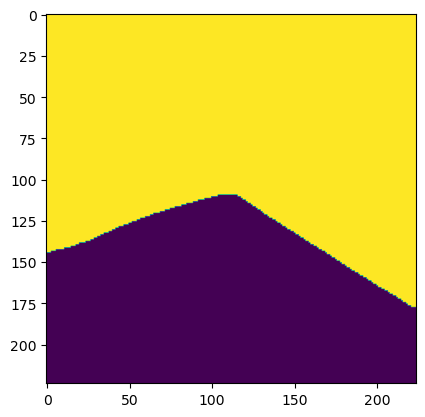

In [333]:
test_outputs=model(tensorized_test_images)
outputs=torch.argmax(test_outputs,axis=1)
out_cpu = outputs.cpu()
outputs_list=out_cpu.detach().numpy()
plt.imshow(outputs_list[0])

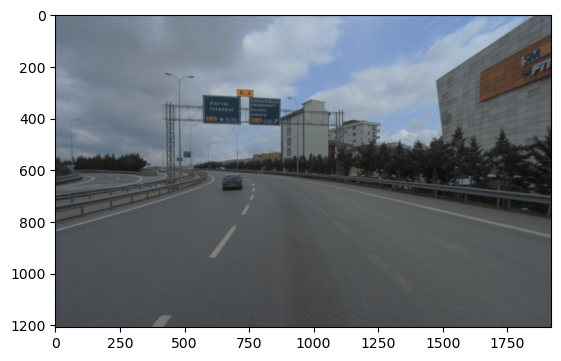

In [334]:
image=plt.imread(test_input_path_list[7])
plt.imshow(image)

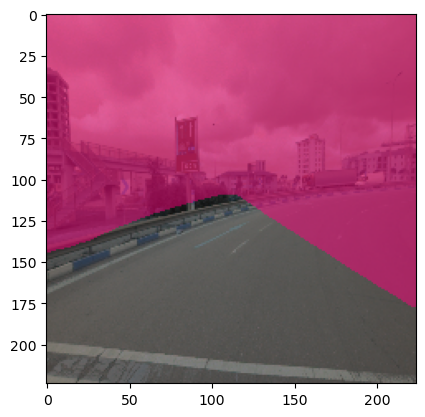

In [335]:
img=cv2.imread(test_input_path_list[0])
mg=cv2.resize(img,(224,224))
mask_ind   = outputs_list == 1
cpy_img  = mg.copy()
mg[outputs_list[0]==1 ,:] = (255, 0, 125)
opac_image=(mg/2+cpy_img/2).astype(np.uint8)
plt.imshow(opac_image)

In [ ]:
mask_ind

### IOU Score With Jaccard Index

In [152]:
target=preprocess.tensorize_mask(test_label_path_list,INPUT_SHAPE,2)
pred_test=test_outputs[0]
pred_test=torch.sigmoid(pred_test)
jaccard_index=JaccardIndex(task='binary',num_classes=2)
jaccard_index(pred_test,target[0])
    
    

tensor(0.5000)